<a href="https://colab.research.google.com/github/Swicano/IntroML_NBs/blob/master/LSTM_Math_OneHot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import *
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [0]:
from numpy import *
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Define a batch function and all that

In [0]:
# a function to generate arbitrary math problems

def Gen_expr(terms=2, val_range=[1,10], trunc='{:.1f}', ops=['+','-','*','/'], rec_max=2, rec_ops = ['', 'sin','exp'], rec_prob = 0.33 ):
  # rec refers to recursion, which is how i originally envisioned parentheticals and functions to be built
  # but flattening arbitrarily recursive lists seemed like more work than just making flat ones to begin
  rec_level = 0
  expr_list = []
  
  term_list = [ trunc.format(random.uniform(val_range[0],val_range[1])) for i in range(terms) ]
  ops_list = random.choices(ops,k=terms-1)
  final = term_list.pop()
  
  # if someone puts in an empty rec list 
  if len(rec_ops)==0: 
    rec_ops = ['']
    
  while term_list:
    if (rec_level<rec_max and random.random()<rec_prob):
      rec_level+=1
      expr_list.append( random.choice(rec_ops)+'(')
    expr_list.append(term_list.pop())
    if rec_level and random.random()<0.4:
      rec_level-=1
      expr_list.append(')')
    expr_list.append(ops_list.pop())  
  
  # then finish off by adding the last number, and closing any open parens
  expr_list.append(final)
  while rec_level:
    rec_level-=1
    expr_list.append(')')
  #expr_str = ''.join(expr_list)
  
  return expr_list

In [0]:
def make_batch(batchsize = 1000, Encodings=False):
  terms = 2
  term_range = [1,9]
  truncformat = '{:.0f}'  # the truncation format  '{:.1f}', {:.0f} for int
  ops=['+']           # the potential operations supported
  recs=['']               # the potential functions ('' = parens)
  rec_prob = 0.33         # the probability of using one of the functions
  max_term_len = max(len(truncformat.format(term_range[0])),len(truncformat.format(term_range[1])))
  max_ops_len  = 1  #max([len(i) for i in ops])  # all ops are size one categories
  max_rec_len  = 2  #max([len(i) for i in recs]) # recs are 'func(' & ')'
  
  inputlen =(max_term_len)*terms        # the +2 takes care of if each term somehow gets parens
  inputlen+=max_ops_len*(terms-1)       # for the longest possible operations in each slot
  inputlen+=int(max_rec_len*(rec_prob*terms+2)) # for the average number of function calls plus som wiggle
  inputlen+=1                           # for the equals sign
  outputlen=max_term_len+2              # assume the answer is max 1 digit larger (this is bad) (and sign)
  encodings = 10+1+len(ops)+len(recs)-1+1+1 # digits0-9,'.', ops, recs-1, nesting, '='
  enc_dict = {}
  for i in range(10):
    enc_dict[str(i)]=i
  enc_dict['.']=10
  enc_dict['=']=11
  enc_dict['nest_depth']=12
  for i,val in enumerate(ops):
    enc_dict[val] = i+13
  for i,val in enumerate(recs):
    if val != '':
      enc_dict[val] = i+13+len(ops)
  enc_out = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'.':10,'+':11,'-':12}
  
  # dict is the better way i think
  #encoding_labels = [i for i in range(10)]
  #encoding_labels.append('.')
  #encoding_labels.append('=')
  #encoding_labels.append('nest_depth')
  #encoding_labels.extend(ops)
  #encoding_labels.extend(recs)
  #encoding_labels.remove('')
  #print(encodings, list(enc_dict), encoding_labels)
  
  # this does a one-hot style encoding
  #                  informat = '{:>'+str(inputlen)+'}'
  #                  outformat = '{:>'+str(outputlen)+'}'
  inbatch  = zeros([batchsize, inputlen+outputlen,encodings])
  outbatch = zeros([batchsize, inputlen+outputlen,len(enc_out)])
  for i in range(batchsize):
    # a hack since it could divide by 0
    test = []
    outtest = ''
    while True:
      try:
        test = Gen_expr(terms=terms, val_range=term_range, trunc=truncformat, ops=ops, rec_max=2, rec_ops = recs, rec_prob =rec_prob)
        outtest = truncformat.format(eval(''.join(test)))
        #print(test,outtest, type(outtest))
      except ZeroDivisionError:
        #print(test, 'err!')
        continue
      else:
        #do stuff?
        break
    in_vect = zeros([1,inputlen+outputlen,encodings])
    out_vect = zeros([1,inputlen+outputlen,len(enc_out)])
    
    ### now we fill the input vector
    # where we start adding it in in reverse order from the equals sign
    loc = inputlen-1 
    in_vect[0,loc,enc_dict['=']]=1
    loc-=1
    for op in test[::-1]:
      in_vect[0,loc,enc_dict['nest_depth']]=in_vect[0,loc+1,enc_dict['nest_depth']]
      #integers and non functions should end here
      if op in enc_dict:
        in_vect[0,loc,enc_dict[op]]=1
      #if we are entering a function, there should be a '('
      elif op[-1] =='(':
        op2 = op[:-1]
        # increase the nest depth (but in reverse)
        in_vect[0,loc,enc_dict['nest_depth']]=in_vect[0,loc,enc_dict['nest_depth']]-1
        # and check again if its in the dict
        if op2 in enc_dict:
          in_vect[0,loc,enc_dict[op2]]=1
      # option 3 we are 'leaving' a nest
      elif op == ')':
        in_vect[0,loc,enc_dict['nest_depth']]=in_vect[0,loc,enc_dict['nest_depth']]+1
      # option 4 we have floats!
      elif set(op).issubset(set(enc_out)):
        loc+=1
        for char in list(op)[::-1]:
          loc-=1
          in_vect[0,loc,enc_dict['nest_depth']]=in_vect[0,loc+1,enc_dict['nest_depth']]
          in_vect[0,loc,enc_dict[char]]=1
      loc-=1 #increment the location
    
    
    ### and then the output vector
    loc=inputlen+outputlen-1
    for char in list(outtest)[::-1]:
      if char in enc_out:
        out_vect[0,loc,enc_out[char]]=1
      loc-=1
    inbatch[i,:,:]=in_vect
    outbatch[i,:,:]=out_vect
  if Encodings:
    return inbatch, outbatch ,enc_dict,enc_out,inputlen+outputlen
  return  inbatch, outbatch

In [0]:
#Generate our validation set, of which we will use number 1 to visualize
Val_in, Val_out, Enc_in, Enc_out, seq_len = make_batch(1000, True)
#print(Val_in[0], Val_out[0]) # subtract 48 to get the number value, 32='', 43='+', 61='=', 40='(', 41=')'
#print(len(Enc_in), seq_len, len(Enc_out))

### Make the net

In [6]:
net=Sequential()
net.add(LSTM(30, batch_input_shape=[None,seq_len,len(Enc_in)], return_sequences=True))
net.add(LSTM(len(Enc_out), return_sequences=True))
net.add(Dense(len(Enc_out), activation = 'softmax'))
net.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

W0703 01:03:21.515999 140293534541696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 01:03:21.587208 140293534541696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 01:03:21.595998 140293534541696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 01:03:22.183882 140293534541696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0703 01:03:22.212762 140293534541696 deprecation_wrappe

In [8]:
epochs = 5000
test_output = zeros([epochs, seq_len,len(Enc_out)])
for k in range(epochs):
  train_in, train_out = make_batch(3000)  # training data
  bnet = net.train_on_batch(train_in, train_out)
  test_output[k,:,:] = net.predict_on_batch(Val_in)[0,:,:]
  if (k % 100 <1):
    print(k, bnet)

  #print("\r epoch: ",k," deviation: ", sum((test_output[k,:,:]-Val_out[0,:,:])**2),"    ")

0 [0.29174513, 0.055833332]
100 [0.23594593, 0.053916667]
200 [0.20388639, 0.057916667]
300 [0.19124003, 0.06]
400 [0.17846745, 0.07455555]
500 [0.15252136, 0.085944444]
600 [0.13548562, 0.102916665]
700 [0.11637015, 0.124805555]
800 [0.09715157, 0.13983333]
900 [0.078169495, 0.14802778]
1000 [0.06289512, 0.14327778]
1100 [0.055015583, 0.14522222]
1200 [0.045343842, 0.14783333]
1300 [0.03938585, 0.15347221]
1400 [0.03441919, 0.15427777]
1500 [0.03170098, 0.15688889]
1600 [0.027613495, 0.16211112]
1700 [0.024729695, 0.16280556]
1800 [0.021138558, 0.16275]
1900 [0.018283296, 0.1635]
2000 [0.01822145, 0.16025]
2100 [0.014868323, 0.1621389]
2200 [0.013826141, 0.16363889]
2300 [0.01187484, 0.16533333]
2400 [0.010415545, 0.164]
2500 [0.008977785, 0.16452777]
2600 [0.008523949, 0.1645]
2700 [0.0076268464, 0.16433333]
2800 [0.0066644954, 0.16619444]
2900 [0.0060310136, 0.16580555]
3000 [0.0057796286, 0.16527778]
3100 [0.0052471305, 0.16488889]
3200 [0.00502927, 0.16469444]
3300 [0.004528663, 0

In [9]:
print(Val_out[0,:,:])
print(test_output[-1,:,:])


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[2.22862121e-02 7.91026950e-02 1.22578172e-02 2.90765706e-02
  6.79574758e-02 9.80028585e-02 9.88000855e-02 1.89954221e-01
  2.23821506e-01 5.07683307e-02 4.35735248e-02 4.41032536e-02
  4.02953885e-02]
 [2.01242790e-02 1.72809824e-01 8.45929980e-03 2.06460021e-02
  6.74936026e-02 8.07401463e-02 1.46998659e-01 1.65795475e-01
  1.41591921e-01 4.92287017e-02 4.60697114e-02 4.15114611e-02
  3.85308489e-02]
 [1.30038699e-02 4.21608180e-01 2.80397828e-03 8.49213544e-03
  6.03497103e-02 3.251045

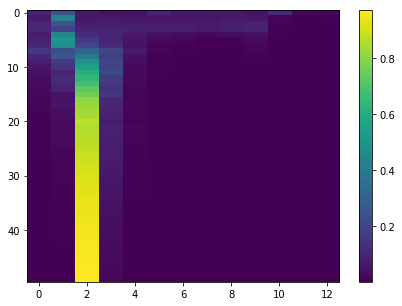

In [27]:
fig=plt.figure(figsize=(7,5))
test_out = test_output[0::100,-1,:]
plt.imshow(test_out,origin='upper',interpolation='nearest',aspect='auto')
plt.colorbar()
plt.show()